# Analysis for MSS19 -Predicted ADs 

In [6]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna 
import pandas as pd
import numpy as np
import itertools
import string
import random
from sklearn.linear_model import LinearRegression
import re
import matplotlib.pyplot as plt
from collections import defaultdict 
import scipy
from scipy import stats
import glob
# import PreprocessingFunctions_LC2AcidBlobs as PF
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import os
import glob
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels
import seaborn as sns


Folder = '20210707/'
if (os.path.isdir('Figures/')):
    print 'Figures folder exists'
else:
    os.mkdir('Figures')
if (os.path.isdir('Figures/'+Folder)):
    print 'Today I will save files in Figures/%s' %Folder
else:
    os.mkdir('Figures/'+Folder)

# DesignedBCs = list(LegacyDF.Barcode)

Figures folder exists
Today I will save files in Figures/20210707/


In [7]:
# Load Support Files 
#Barcode Map
# 'ADseq'=ADBC 'Barcode'==CompoundBarcode and DNAseq 
# CompositeBarcodeMapDF = pd.read_pickle('../KeySupportFiles/CompositeBarcodesDF')
AD_DF_RawActivities = pd.read_pickle('../Preprocessing/pickleFiles/AD_DF_pickle_20210705_NormByNoADControl')
# AD_DF_Zscores = pd.read_pickle('../Preprocessing/pickleFiles/MSS19_AD_DF_Zscores_nextseq202100706_10bcs')
CandidateADsToTestDF = pd.read_pickle('../Preprocessing/pickleFiles/MSS19_DesignedFragments_Zscores_10plusBCs_20210209')

WTDF_Exp2 = pd.read_pickle('../../Analysis_LC2_AcidBlobLibrary/Analysis/pickleFiles/MSS18_WTDF_afterProcessingStep2')


# Support Variables
Replicates = ['MSS19_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed',
        'MSS19_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed',
             'MSS19_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed'             ]
ListofExperiments = ['Sort1','Sort2','Sort3','Sort4']
ColName2ExpNameDict = {        'MSS19_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort1',
        'MSS19_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort2',
        'MSS19_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort3',
    'MSS19_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed':'Sort4',
}
ExpName2ColNameDict = {v: k for k, v in ColName2ExpNameDict.iteritems()}
RegionClasses = [ 'Controls', 'Prediction', 'Random', 'Uniprot', 'GoogleSheet', 'ChopCRX','Choi_ADs']


Activity = 'MSS19_Activity_Mean'#'MSS19_Activity_Zscore'
CurrentSEM = 'MSS19_Activity_SEM'# 'MSS19_Activity_Zscore_SEM'
CandidateADsToTestDF['Detected'] = ~np.isnan(CandidateADsToTestDF[Activity])
CandidateADsToTestDF['uniprotIDs']=CandidateADsToTestDF.GeneName.str.split('|',expand=True)[1]
print '%i ADs detected and used for downstream analysis'% sum(CandidateADsToTestDF.Detected)
CandidateADsToTestDF.columns


428 ADs detected and used for downstream analysis


Index([u'End', u'GeneName', u'Length', u'ProteinRegionSeq', u'RegionType',
       u'Start', u'uniprotIDs', u'AAseqLengths', u'MSS19_Activity_Zscore',
       u'MSS19_Activity_Zscore_SEM', u'MSS19_Activity_Mean',
       u'MSS19_Activity_SEM', u'MSS19_Activity_STD', u'Detected'],
      dtype='object')

# Add more column annotations


In [8]:
def findMutant(genename2find):
    for i, row in CandidateADsToTestDF.iterrows():
        genename = str(row.GeneName)
        hits = re.search(genename2find,genename)
        if hits:
            print row[['GeneName','RegionType','Start','End',Activity]]
findMutant('Q8NHY6')
def printPosNegControls(column='NegativeControls'):
    indx = CandidateADsToTestDF[column]
    tempDF = CandidateADsToTestDF[indx]
    tempDF =tempDF.sort_values(by=Activity,ascending=0) 
    tempDF = tempDF[['GeneName',Activity,'RegionType','ProteinRegionSeq','Start','End',CurrentSEM]]
    return tempDF

#### Josh Tycko and Lacra Bintu activator KRABs
    Q96IT1 ZN496 - Not in library
    Q96LX8 Znf 597 - Not in library
    Q8WTR7 ZnF473 2 predictions at flanks. We also tested the uniprot region. uniprot region has very high SEM but >10 integrations in each replicate. It is a strong AD in 2/3 replicates.
    Q8NHY6 ZFP28 2nd KRAB domain - Not in library

In [9]:
# KRAB domains
PredictionsThatOverlapKRABs = [
'ZNF12_HUMAN',
'ZN778_HUMAN',
'ZN777_HUMAN',
'ZN571_HUMAN',
'ZN561_HUMAN',
'ZN555_HUMAN',
'ZN551_HUMAN',
'ZN529_HUMAN',
'ZN473_HUMAN',#This one is an activator in Tycko et al 2020
'ZN419_HUMAN',
'ZN316_HUMAN',
'ZN283_HUMAN',
'ZN211_HUMAN',
'ZIK1_HUMAN',
# 'ZN500_HUMAN',#protein contains a KRAB domain but it does not overlap the prediction
'ZNF12_HUMAN',
#'ZSC30_HUMAN',#protein contains a KRAB domain but it does not overlap the prediction
#'ZKSC8_HUMAN',#protein contains a KRAB domain but it does not overlap the prediction
]
# find all the Znf genes and/or KRAB genes
def SearchGeneNamesWaList(CandidateADsToTestDF,PredictionsThatOverlapKRABs,FinalColumnName,CurrentRegion='RegionType',printoutput=1):
    Zindx = np.zeros_like(CandidateADsToTestDF.Length)
    for i,row in CandidateADsToTestDF.iterrows():
        if row[CurrentRegion]=='Prediction':
            genename = str(row.GeneName)
            for querry in PredictionsThatOverlapKRABs:
                hits = re.search(querry,genename)
                if hits:
    #                 print row[['GeneName','RegionType','Start','End']]
                    Zindx[i]= 1
    if printoutput ==1:
        print 'There are %i entries in the list and %i overlaps found' %(len(PredictionsThatOverlapKRABs), sum(Zindx))
    Zindx = Zindx>0
    CandidateADsToTestDF[FinalColumnName]=Zindx
    tempDF = CandidateADsToTestDF[Zindx]
    tempDF[['GeneName','RegionType','Start','End']]
SearchGeneNamesWaList(CandidateADsToTestDF,PredictionsThatOverlapKRABs,'OverlapsKRAB')
tempDF = printPosNegControls('OverlapsKRAB')
tempDF
# indx = CandidateADsToTestDF.GeneName=='>sp|Q8WTR7|ZN473_HUMAN'
# CandidateADsToTestDF[indx][['GeneName','RegionType','Start','End',Activity,'ProteinRegionSeq',CurrentSEM]]

There are 15 entries in the list and 16 overlaps found


,GeneName,MSS19_Activity_Mean,RegionType,ProteinRegionSeq,Start,End,MSS19_Activity_SEM
87,>sp|Q8WTR7|ZN473_HUMAN,265.583539,Prediction,LMEDFFEEGFSQEIIEMLSKDGFWNSNFGEACIEDTWLDSLL,84.0,126.0,12.225262
86,>sp|Q8WTR7|ZN473_HUMAN,256.527362,Prediction,EEFVTLKDVGMDFTLGDWEQLGLEQGDTFWDTALDNCQDLFLLDPP,2.0,48.0,21.687162
97,>sp|Q9ULD5|ZN777_HUMAN,227.015964,Prediction,EEQDEEEEEEEEDELPQHLQSLGQLSGRYEASMYQTPLPGEM,453.0,495.0,7.939884
0,>sp|Q8N587|ZN561_HUMAN,223.334567,Prediction,VEDYLASGYQDSVTFDDVAVDFTPEEWALLDTTEKYLYRD,28.0,68.0,7.511416
82,>sp|Q7Z3V5|ZN571_HUMAN,220.062801,Prediction,VAIDFSQEEWECLDPAQRDLYRDVMLENYSNLISLDLE,10.0,48.0,5.607163
69,>sp|Q96HQ0|ZN419_HUMAN,216.764097,Prediction,PAQVPVAADLLTDHEEGYVTFEDVAVYFSQEEWRLLDD,8.0,46.0,4.827722
12,>sp|A6NFI3|ZN316_HUMAN,212.098269,Prediction,PRDEDLEEEEEEEEDEDEDDLLTAGCQELVTFEDVAVYFSLEEWER...,128.0,185.0,7.574355
57,>sp|Q8NEP9|ZN555_HUMAN,208.114172,Prediction,DVAVDFTLEEWALLDSAQRDLYRDVMLETFQNLASVDDE,7.0,46.0,28.262121
40,>sp|Q3SY52|ZIK1_HUMAN,204.824824,Prediction,DEWGLLDEAQRLLYLEVMLENFALVASLGCGHGTEDEET,38.0,77.0,23.512899
92,>sp|Q6P280|ZN529_HUMAN,204.773392,Prediction,PEVEFPDQFFTVLTMDHELVTLRDVVINFSQEEWEYLDSA,19.0,59.0,13.929047


#### Define positive and negative controls

In [10]:
# clean up negative controls
tempNegativeControls = CandidateADsToTestDF.RegionType=='Controls'
tempKRABddomains = CandidateADsToTestDF.OverlapsKRAB
# combine AD lists to make positive controls from both AD lists
tempPositiveControls = ((CandidateADsToTestDF.RegionType=='GoogleSheet')|
                        (CandidateADsToTestDF.RegionType=='Uniprot')
                        |(CandidateADsToTestDF.RegionType=='Choi_ADs')# we decided to not include the Chpoi 2000 regions as positive controls
                       )
#KRAB domains in uniprot list. 
# TODO flag these in the OverlapsKRAB column.
# >sp|Q8WTR7|ZN473_HUMAN is on Uniprot list ofADs but is actually a KRAB domain. 
# The uniprot region [5-75] is is not an AD in our data. But two overlapping predictions [2-48],[84-126] are ADS. 
indx = (CandidateADsToTestDF.GeneName=='>sp|Q8WTR7|ZN473_HUMAN')&(CandidateADsToTestDF.RegionType=='Uniprot')
tempNegativeControls[indx] = True
tempPositiveControls[indx] = False
tempKRABddomains[indx]     = True #This is a KRAB domain but it is not a Repression domain
#Remove other KRAB domains from the positive controls column.
indx = (CandidateADsToTestDF.GeneName=='>sp|A6NFI3|ZN316_HUMAN')&(CandidateADsToTestDF.RegionType=='Uniprot')
tempNegativeControls[indx] = True
tempPositiveControls[indx] = False
tempKRABddomains[indx]     = True
indx = (CandidateADsToTestDF.GeneName=='>sp|Q9ULD5|ZN777_HUMAN')&(CandidateADsToTestDF.RegionType=='Uniprot')
tempNegativeControls[indx] = True
tempPositiveControls[indx] = False
tempKRABddomains[indx]     = True


# A few of the 'Controls' should be in the positive controls category
indx = (CandidateADsToTestDF.GeneName=='DWs')&(CandidateADsToTestDF.RegionType=='Controls')
tempNegativeControls[indx] = False
tempPositiveControls[indx] = True
indx = (CandidateADsToTestDF.GeneName=='DFs')&(CandidateADsToTestDF.RegionType=='Controls')
tempNegativeControls[indx] = False
tempPositiveControls[indx] = True
indx = (CandidateADsToTestDF.GeneName=='HIF1a_AD2_46_RK>D')&(CandidateADsToTestDF.RegionType=='Controls')
tempNegativeControls[indx] = False
tempPositiveControls[indx] = True
indx = (CandidateADsToTestDF.GeneName=='HIF1a_AD2_46_QN>Emut7to29')&(CandidateADsToTestDF.RegionType=='Controls')
tempNegativeControls[indx] = False
tempPositiveControls[indx] = True

# add new columns to masterDF with new groupings
CandidateADsToTestDF['NegativeControls']=tempNegativeControls
CandidateADsToTestDF['PositiveControls']=tempPositiveControls
CandidateADsToTestDF['OverlapsKRAB']=tempKRABddomains
CandidateADsToTestDF['Predictions']=CandidateADsToTestDF.RegionType=='Prediction'
CandidateADsToTestDF['RandomRegions']=CandidateADsToTestDF.RegionType=='Random'
CandidateADsToTestDF['ChopCRX']=CandidateADsToTestDF.RegionType=='ChopCRX'
ListofExperiments = ['RandomRegions', 'Predictions','PositiveControls',
                     'NegativeControls','ChopCRX']
tempDF=CandidateADsToTestDF[ListofExperiments]
CandidateADsToTestDF['ExpType'] = tempDF.idxmax(1).to_frame('ExpType')


tempDF = printPosNegControls('NegativeControls')
print 'There are %i Negative Controls in design'%len(tempDF)
tempDF = printPosNegControls('PositiveControls')
print 'There are %i Positive Controls in design'%len(tempDF)
tempDF


# 


There are 23 Negative Controls in design
There are 94 Positive Controls in design


,GeneName,MSS19_Activity_Mean,RegionType,ProteinRegionSeq,Start,End,MSS19_Activity_SEM
434,HIF1a_AD2_46_QN>Emut7to29,325.172990,Controls,RLLGQSMDESGLPELTSYDCEVEAPIEGSRNLLQGEELLRALDQVN,0.0,1.0,7.307922
339,CITED2CITED2_N Acid blob library fragment,309.581693,GoogleSheet,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD,220.0,258.0,12.873568
340,CITED2Cterm,298.212767,GoogleSheet,TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTDFVCKQQP...,220.0,269.0,8.115201
342,ETV5/ETV/PEA3/ERMNterm,284.892994,GoogleSheet,DLAHDSEELFQDLSQLQEAWLAEAQVPDDEQ,38.0,68.0,29.006924
327,VP16H2,280.244312,GoogleSheet,FTPHDSAPYGALDMADFEFEQMFTDALGIDEYGG,457.0,490.0,6.766366
344,Hif1aHif1-AD2_46 Acid blob library fragment,279.270923,GoogleSheet,RLLGQSMDESGLPQLTSYDCEVNAPIQGSRNLLQGEELLRALDQVN,781.0,826.0,49.277712
326,VP16MVS N_C (acid blob library fragment,273.539675,GoogleSheet,PTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDGDSP,418.0,456.0,8.911584
414,NF-E2,270.798481,Choi_ADs,MSPCPPQQSRNRVIQLSTSELGEMELTWQEIMSITELQGLNAPSEP...,0.0,1.0,NaN
388,HSF-2,270.568244,Choi_ADs,EVLSSVDKPIEVDELLDSSLDPEPTQSKLVRLEPLTEAEASEATLF...,0.0,1.0,35.057170
352,c-MybLC1_N,270.125743,GoogleSheet,PAAAAIQRHYNDEDPEKEKRIKELELLLMSTENELKGQQ,NaN,NaN,7.316283


#### Set Threshold for active ADs

In [11]:
OnOffThresh = 221 #95thpercentile of Random Regions 8/146 are active at this thresold
LowActivityThresh =200 # Activity of the empty TF
Sets = ['PositiveControls','NegativeControls','RandomRegions','Predictions']
print 'Using the 95the percentile of Random Regions as a threshold for Strong AD activity %i '%OnOffThresh
print 'Using the activity of the No AD TF (200) as a threshold for active/inactive\n'
for regiontype in Sets:
    indx = CandidateADsToTestDF[regiontype]
    indx2 = (CandidateADsToTestDF[regiontype] )&CandidateADsToTestDF.Detected
    print '%s:\nN = %i designed\t%i detected'%(regiontype,sum(indx),sum(indx2))
    tempDF = CandidateADsToTestDF[indx]
    Nstrong = sum(tempDF[Activity]>OnOffThresh)
    Nactive = sum(tempDF[Activity]>LowActivityThresh)
    print '%i are Strong ADs'%Nstrong
    print '%.2f percent of detected' %(100.0*Nstrong/sum(indx2))
    print '%i are active ADs'%Nactive
    print '%.2f percent of detected\n' %(100.0*Nactive/sum(indx2))

CandidateADsToTestDF['StrongADs'] = CandidateADsToTestDF[Activity]>OnOffThresh
CandidateADsToTestDF['ActiveADs'] = CandidateADsToTestDF[Activity]>LowActivityThresh

Using the 95the percentile of Random Regions as a threshold for Strong AD activity 221 
Using the activity of the No AD TF (200) as a threshold for active/inactive

PositiveControls:
N = 94 designed	89 detected
52 are Strong ADs
58.43 percent of detected
75 are active ADs
84.27 percent of detected

NegativeControls:
N = 23 designed	20 detected
4 are Strong ADs
20.00 percent of detected
15 are active ADs
75.00 percent of detected

RandomRegions:
N = 150 designed	146 detected
8 are Strong ADs
5.48 percent of detected
55 are active ADs
37.67 percent of detected

Predictions:
N = 150 designed	149 detected
58 are Strong ADs
38.93 percent of detected
108 are active ADs
72.48 percent of detected



In [12]:
#
indx = CandidateADsToTestDF.PositiveControls&CandidateADsToTestDF.StrongADs
a,b = sum(indx),sum((CandidateADsToTestDF.PositiveControls&CandidateADsToTestDF.Detected))
print 'Of %i of %i detected Positive Controls have high activity %.1f percent'%(a,b,100.0*a/b)
indx = CandidateADsToTestDF.NegativeControls&CandidateADsToTestDF.StrongADs
a,b = sum(indx),sum((CandidateADsToTestDF.NegativeControls&CandidateADsToTestDF.Detected))
print 'Of %i of %i detected Negative Controls have high activity %.1f percent'%(a,b,100.0*a/b)
# print 'Both have high SEM'
CandidateADsToTestDF[indx][['GeneName','ProteinRegionSeq',Activity,CurrentSEM]]



Of 52 of 89 detected Positive Controls have high activity 58.4 percent
Of 4 of 20 detected Negative Controls have high activity 20.0 percent


,GeneName,ProteinRegionSeq,MSS19_Activity_Mean,MSS19_Activity_SEM
167,>sp|Q9ULD5|ZN777_HUMAN,VTFDDVAVHFSEQEWGNLSEWQKELYKNVMRGNYESLVSMDYAISK...,229.917211,21.436564
425,DEs,DEDEDEDEDEDEDEDEDEDEDEDEDEDEDEDEDEDEDEDE,234.589842,NaN
426,Ds,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD,221.988718,21.578944
432,VP16_F442A,PTDVSLGDELHLDGEDVAMAHADALDDADLDMLGDGDSP,232.560501,18.343757


In [13]:
# inactive Positive controls
indx = CandidateADsToTestDF.Detected&(~CandidateADsToTestDF.ActiveADs)&CandidateADsToTestDF.PositiveControls
CandidateADsToTestDF[indx]

,End,GeneName,Length,ProteinRegionSeq,RegionType,Start,uniprotIDs,AAseqLengths,MSS19_Activity_Zscore,MSS19_Activity_Zscore_SEM,...,Detected,OverlapsKRAB,NegativeControls,PositiveControls,Predictions,RandomRegions,ChopCRX,ExpType,StrongADs,ActiveADs
162,450.0,>sp|P11473|VDR_HUMAN,51.0,YRCLSFQPECSMKLTPLVLEVFGNEIS,Uniprot,400.0,P11473,16,-0.379196,0.277517,...,True,False,False,True,False,False,False,PositiveControls,False,False
166,88.0,>sp|P01106|MYC_HUMAN,89.0,MPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPS...,Uniprot,0.0,P01106,16,-1.023624,0.692394,...,True,False,False,True,False,False,False,PositiveControls,False,False
331,764.0,STAT3TAD,46.0,SNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDMELTSE,GoogleSheet,719.0,None,16,-0.572579,0.653428,...,True,False,False,True,False,False,False,PositiveControls,False,False
346,575.0,Hif1aNterm AD1,45.0,FKLELVEKLFAEDTEAKNPFSTQDTDLDLEMLAPYIPMDDDFQLR,GoogleSheet,531.0,None,16,-0.323613,0.628971,...,True,False,False,True,False,False,False,PositiveControls,False,False
348,74.0,NRLMinimal,35.0,GSTPYSSVPPSPTFSEPGMVGATEGTRPGLEELYW,GoogleSheet,40.0,None,16,-0.357437,0.179676,...,True,False,False,True,False,False,False,PositiveControls,False,False
384,1.0,ELF-1,87.0,MAAVVQQNDLVFEFASNVMEDERQLGDPAIFPAVIVEHVPGADILN...,Choi_ADs,0.0,None,16,-1.216230,0.294565,...,True,False,False,True,False,False,False,PositiveControls,False,False
387,1.0,c-Jun_2,20.0,ETPPLSPIDMESQERIKAER,Choi_ADs,0.0,None,16,-0.817240,0.211819,...,True,False,False,True,False,False,False,PositiveControls,False,False
397,1.0,FBP,36.0,PDYSAAWAEHYRQQAAYYAQTSPQGMPQHPPAPQGQ,Choi_ADs,0.0,None,16,-0.784958,0.373140,...,True,False,False,True,False,False,False,PositiveControls,False,False
398,1.0,HSF-1,60.0,EKCLSVACLDKNELSDHLDAMDSNLDNLQTMLSSHGFSVDTSALLD...,Choi_ADs,0.0,None,16,-0.965347,0.156796,...,True,False,False,True,False,False,False,PositiveControls,False,False
402,1.0,"HNF1(LFB1,TCF-1)",38.0,LAMDTYSGPPPGPGPGPALPAHSSPGLPPPALSPSKVH,Choi_ADs,0.0,None,16,-0.324035,0.620944,...,True,False,False,True,False,False,False,PositiveControls,False,False


### How many of the predicted ADs are new?

In [14]:
# how many random regions overlap uniprot ADs?
# who are the predictions that overlap Uniprot ADs?
predictedRegionsThatOverlapUniprotADs = [ # 17 uniprot overlaps in original predictions
 '>sp|O00716|E2F3_HUMAN',
 '>sp|O15391|TYY2_HUMAN',
 '>sp|O43889|CREB3_HUMAN',
 '>sp|P18850|ATF6A_HUMAN',
 '>sp|P35716|SOX11_HUMAN',
 '>sp|P36956|SRBP1_HUMAN',
 '>sp|Q00613|HSF1_HUMAN',
 '>sp|Q01094|E2F1_HUMAN',
 '>sp|Q04206|TF65_HUMAN',
 '>sp|Q12772|SRBP2_HUMAN',
 '>sp|Q14209|E2F2_HUMAN',
 '>sp|Q15329|E2F5_HUMAN',
 '>sp|Q16254|E2F4_HUMAN',
 '>sp|Q16665|HIF1A_HUMAN',
 '>sp|Q96BA8|CR3L1_HUMAN',
 '>sp|Q9UBX2|DUX4_HUMAN',
 '>sp|Q9Y2N7|HIF3A_HUMAN']
#tag the predictions that overlap uniprot ADs
Uindx = np.zeros_like(CandidateADsToTestDF.Length)
for i,row in CandidateADsToTestDF.iterrows():
#     for querry in predictedRegionsThatOverlapUniprotADs:
    if row.GeneName in predictedRegionsThatOverlapUniprotADs:
        Uindx[i]= 1
Uindx = Uindx>0
CandidateADsToTestDF['OverlapsUniprotAD']=Uindx


# check if the new ADs are on genes that in the googledoc list--not checking for region overlap yet
GoogleSheetADs_Jan21 = pd.read_csv('supportfiles/Human_Activation_Domains_GoogleSheet_20210108.csv')
googledocUniprotids_new = GoogleSheetADs_Jan21.uniprotID
SearchGeneNamesWaList(CandidateADsToTestDF,googledocUniprotids_new,'TEMPOverlapsNewGoogleDoc',printoutput=0)
# fix the overlaps googleDoc column to check for coordinate overlaps

indx = CandidateADsToTestDF.Predictions&CandidateADsToTestDF.TEMPOverlapsNewGoogleDoc
CandidateADsToTestDF['OverlapsNewGoogleDoc'] = [False]*len(CandidateADsToTestDF)
tempDF = CandidateADsToTestDF[indx]
for i, row in tempDF.iterrows():
    tempUniprotID = row.uniprotIDs
    tempDF2 = GoogleSheetADs_Jan21[GoogleSheetADs_Jan21.uniprotID==tempUniprotID]
    for j, row2 in tempDF2.iterrows():
        if (row.Start < row2.End)&(row.End>row2.Start):
            CandidateADsToTestDF.at[i,'OverlapsNewGoogleDoc']=True

In [15]:
# 
# print 'There are %i e that overlap Uniprot ADs and %i regions in the experiment' %(len(predictedRegionsThatOverlapUniprotADs), sum(Uindx))
indx = CandidateADsToTestDF.OverlapsUniprotAD
print 'There are %i matches in the experiment to genes with uniprot ADs' % sum(indx)
indx = CandidateADsToTestDF.OverlapsUniprotAD& (CandidateADsToTestDF.RegionType=='Prediction')
print '%i are Predictions' % sum(indx)
indx = CandidateADsToTestDF.OverlapsUniprotAD&(CandidateADsToTestDF.RegionType=='Random')
print '%i are Random'% sum(indx)
indx = CandidateADsToTestDF.OverlapsUniprotAD&(CandidateADsToTestDF.RegionType=='Uniprot')
print '%i are UniprotControls'% sum(indx)

# who are the predictions that are new?
#strong ADs
ActivePredictions = (CandidateADsToTestDF.RegionType=='Prediction')& CandidateADsToTestDF.StrongADs
print '\nThere are %i STRONG ADs in the predicted set'% sum(ActivePredictions)
#active ADs
# ActivePredictions = (CandidateADsToTestDF.RegionType=='Prediction')& CandidateADsToTestDF.ActiveADs#StrongADs
# print '\nThere are %i ACTIVE ADs in the predicted set'% sum(ActivePredictions)

Active_uniprot = CandidateADsToTestDF.OverlapsUniprotAD& ActivePredictions
print '%i were on Uniprot domain list'% sum(Active_uniprot)

Active_googleDocJan21 = CandidateADsToTestDF.OverlapsNewGoogleDoc&ActivePredictions
print '%i were on Jan 2021 updated GoogleDoc AD list'% sum(Active_googleDocJan21)

Active_googleDocJan21_ANDuniprot = CandidateADsToTestDF.OverlapsUniprotAD&Active_googleDocJan21
Zn473indx = (CandidateADsToTestDF.GeneName=='>sp|Q8WTR7|ZN473_HUMAN')&(CandidateADsToTestDF.Predictions)
print 'Plus there are %i regions on ZN473 that are published by Bintu Lab but not on of my lists of ADs'%sum(Zn473indx)
print '%i were on Uniprot domain list AND on Jan 2021 updated GoogleDoc AD list'% sum(Active_googleDocJan21_ANDuniprot)
Active_googleDocJan21_ORuniprot = Active_uniprot|Active_googleDocJan21
print '%i were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list\n'% sum(Active_googleDocJan21_ORuniprot)
Active_googleDocJan21_ORuniprotORbintu = Active_uniprot|Active_googleDocJan21|Zn473indx
print '%i were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list OR Bintu\n'% sum(Active_googleDocJan21_ORuniprotORbintu)


print 'How many of the %i Predictions overlap known ADs?' %sum(CandidateADsToTestDF.Predictions)
PREDuniprot = CandidateADsToTestDF.OverlapsUniprotAD&CandidateADsToTestDF.Predictions
print '%i of the predicted ADs overlapped the Uniprot ADs \n%.1f percent'%(sum(PREDuniprot),(100.0*sum(PREDuniprot)/sum(CandidateADsToTestDF.Predictions)))
PREDgoogledoc = CandidateADsToTestDF.OverlapsNewGoogleDoc&CandidateADsToTestDF.Predictions
print '%i of the predicted ADs over the Jan2021 GoogleDoc ADs \n%.1f percent'%(sum(PREDgoogledoc),(100.0*sum(PREDgoogledoc)/sum(CandidateADsToTestDF.Predictions)))

PREDuniprotORgoogledoc = PREDuniprot|PREDgoogledoc
print '%i of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs \n%.1f percent\n'%(sum(PREDuniprotORgoogledoc),(100.0*sum(PREDuniprotORgoogledoc)/sum(CandidateADsToTestDF.Predictions)))
PREDuniprotORgoogledocORBintu = PREDuniprot|PREDgoogledoc|Zn473indx
print '%i of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs OR Bintu Zn473 \n%.1f percent\n'%(sum(PREDuniprotORgoogledocORBintu),(100.0*sum(PREDuniprotORgoogledocORBintu)/sum(CandidateADsToTestDF.Predictions)))
PREDgoogledocORBintu = PREDgoogledoc|Zn473indx
print '%i of the predicted ADs overlapped the GoogleDoc OR Bintu Zn473 \n%.1f percent\n'%(sum(PREDgoogledocORBintu),(100.0*sum(PREDgoogledocORBintu)/sum(CandidateADsToTestDF.Predictions)))

ActiveORuniprotORgoogledoc = ActivePredictions|PREDuniprotORgoogledocORBintu
print '%i of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs OR Bintu Zn473 OR are Strongly active in the assay, \n%.1f percent'%(sum(ActiveORuniprotORgoogledoc),(100.0*sum(ActiveORuniprotORgoogledoc)/sum(CandidateADsToTestDF.Predictions)))

print 'We found %i new Strong ADs'% (sum(ActivePredictions)-sum(PREDuniprotORgoogledocORBintu))

There are 29 matches in the experiment to genes with uniprot ADs
17 are Predictions
0 are Random
12 are UniprotControls

There are 58 STRONG ADs in the predicted set
11 were on Uniprot domain list
9 were on Jan 2021 updated GoogleDoc AD list
Plus there are 2 regions on ZN473 that are published by Bintu Lab but not on of my lists of ADs
2 were on Uniprot domain list AND on Jan 2021 updated GoogleDoc AD list
18 were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list

20 were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list OR Bintu

How many of the 150 Predictions overlap known ADs?
17 of the predicted ADs overlapped the Uniprot ADs 
11.3 percent
12 of the predicted ADs over the Jan2021 GoogleDoc ADs 
8.0 percent
26 of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs 
17.3 percent

28 of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs OR Bintu Zn473 
18.7 percent

14 of the predicted ADs overlapped the GoogleDoc OR Bintu Zn473 
9.3 percent



In [16]:
# how many new ADs have detectable activity

In [17]:
# 
# print 'There are %i e that overlap Uniprot ADs and %i regions in the experiment' %(len(predictedRegionsThatOverlapUniprotADs), sum(Uindx))
indx = CandidateADsToTestDF.OverlapsUniprotAD
print 'There are %i matches in the experiment to genes with uniprot ADs' % sum(indx)
indx = CandidateADsToTestDF.OverlapsUniprotAD& (CandidateADsToTestDF.RegionType=='Prediction')
print '%i are Predictions' % sum(indx)
indx = CandidateADsToTestDF.OverlapsUniprotAD&(CandidateADsToTestDF.RegionType=='Random')
print '%i are Random'% sum(indx)
indx = CandidateADsToTestDF.OverlapsUniprotAD&(CandidateADsToTestDF.RegionType=='Uniprot')
print '%i are UniprotControls'% sum(indx)

# who are the predictions that are new?
#active ADs
ActivePredictions = (CandidateADsToTestDF.RegionType=='Prediction')& CandidateADsToTestDF.ActiveADs#StrongADs
print '\nThere are %i ACTIVE ADs in the predicted set'% sum(ActivePredictions)

Active_uniprot = CandidateADsToTestDF.OverlapsUniprotAD& ActivePredictions
print '%i were on Uniprot domain list'% sum(Active_uniprot)

Active_googleDocJan21 = CandidateADsToTestDF.OverlapsNewGoogleDoc&ActivePredictions
print '%i were on Jan 2021 updated GoogleDoc AD list'% sum(Active_googleDocJan21)

Active_googleDocJan21_ANDuniprot = CandidateADsToTestDF.OverlapsUniprotAD&Active_googleDocJan21
Zn473indx = (CandidateADsToTestDF.GeneName=='>sp|Q8WTR7|ZN473_HUMAN')&(CandidateADsToTestDF.Predictions)
print 'Plus there are %i regions on ZN473 that are published by Bintu Lab but not on of my lists of ADs'%sum(Zn473indx)
print '%i were on Uniprot domain list AND on Jan 2021 updated GoogleDoc AD list'% sum(Active_googleDocJan21_ANDuniprot)
Active_googleDocJan21_ORuniprot = Active_uniprot|Active_googleDocJan21
print '%i were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list\n'% sum(Active_googleDocJan21_ORuniprot)
Active_googleDocJan21_ORuniprotORbintu = Active_uniprot|Active_googleDocJan21|Zn473indx
print '%i were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list OR Bintu\n'% sum(Active_googleDocJan21_ORuniprotORbintu)


print 'How many of the %i Predictions overlap known ADs?' %sum(CandidateADsToTestDF.Predictions)
PREDuniprot = CandidateADsToTestDF.OverlapsUniprotAD&CandidateADsToTestDF.Predictions
print '%i of the predicted ADs overlapped the Uniprot ADs \n%.1f percent'%(sum(PREDuniprot),(100.0*sum(PREDuniprot)/sum(CandidateADsToTestDF.Predictions)))
PREDgoogledoc = CandidateADsToTestDF.OverlapsNewGoogleDoc&CandidateADsToTestDF.Predictions
print '%i of the predicted ADs over the Jan2021 GoogleDoc ADs \n%.1f percent'%(sum(PREDgoogledoc),(100.0*sum(PREDgoogledoc)/sum(CandidateADsToTestDF.Predictions)))

PREDuniprotORgoogledoc = PREDuniprot|PREDgoogledoc
print '%i of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs \n%.1f percent\n'%(sum(PREDuniprotORgoogledoc),(100.0*sum(PREDuniprotORgoogledoc)/sum(CandidateADsToTestDF.Predictions)))
PREDuniprotORgoogledocORBintu = PREDuniprot|PREDgoogledoc|Zn473indx
print '%i of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs OR Bintu Zn473 \n%.1f percent\n'%(sum(PREDuniprotORgoogledocORBintu),(100.0*sum(PREDuniprotORgoogledocORBintu)/sum(CandidateADsToTestDF.Predictions)))
PREDgoogledocORBintu = PREDgoogledoc|Zn473indx
print '%i of the predicted ADs overlapped the GoogleDoc OR Bintu Zn473 \n%.1f percent\n'%(sum(PREDgoogledocORBintu),(100.0*sum(PREDgoogledocORBintu)/sum(CandidateADsToTestDF.Predictions)))

ActiveORuniprotORgoogledoc = ActivePredictions|PREDuniprotORgoogledocORBintu
print '%i of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs OR Bintu Zn473 OR are Strongly active in the assay, \n%.1f percent'%(sum(ActiveORuniprotORgoogledoc),(100.0*sum(ActiveORuniprotORgoogledoc)/sum(CandidateADsToTestDF.Predictions)))

print 'We found %i new ADs'% (sum(ActivePredictions)-sum(PREDuniprotORgoogledocORBintu))

There are 29 matches in the experiment to genes with uniprot ADs
17 are Predictions
0 are Random
12 are UniprotControls

There are 108 ACTIVE ADs in the predicted set
14 were on Uniprot domain list
12 were on Jan 2021 updated GoogleDoc AD list
Plus there are 2 regions on ZN473 that are published by Bintu Lab but not on of my lists of ADs
3 were on Uniprot domain list AND on Jan 2021 updated GoogleDoc AD list
23 were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list

25 were on Uniprot domain list OR on Jan 2021 updated GoogleDoc AD list OR Bintu

How many of the 150 Predictions overlap known ADs?
17 of the predicted ADs overlapped the Uniprot ADs 
11.3 percent
12 of the predicted ADs over the Jan2021 GoogleDoc ADs 
8.0 percent
26 of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs 
17.3 percent

28 of the predicted ADs overlapped the GoogleDoc OR Uniprot ADs OR Bintu Zn473 
18.7 percent

14 of the predicted ADs overlapped the GoogleDoc OR Bintu Zn473 
9.3 percent

In [18]:
# add a column for Seaborn plotting with ExperiemntType
tempString = np.zeros_like(CandidateADsToTestDF.GeneName)
tempString[CandidateADsToTestDF.RandomRegions] = 'Random Regions'
tempString[CandidateADsToTestDF.Predictions] = 'Predicted ADs'
tempString[CandidateADsToTestDF.PositiveControls] = 'Published ADs'
tempString[CandidateADsToTestDF.NegativeControls] = 'Negative Controls'
tempString[CandidateADsToTestDF.ChopCRX] ='ChopCRX'
CandidateADsToTestDF['ExperimentType']= tempString


In [19]:
indx = PREDgoogledocORBintu & (~PREDuniprot)
print sum(indx)
indx = PREDgoogledocORBintu & (~PREDuniprot)&(~PREDuniprot)
print sum(indx)
CandidateADsToTestDF[indx][['GeneName','ProteinRegionSeq','Start']]
# temp = CandidateADsToTestDF[indx]
# len(set(temp.GeneName))

11
11


,GeneName,ProteinRegionSeq,Start
16,>sp|P78545|ELF3_HUMAN,DELSWIIELLEKDGMAFQEALDPGPFDQGSPFAQELLDDG,133.0
21,>sp|P43268|ETV4_HUMAN,MDPGSLPPLDSEDLFQDLSHFQETWLAEAQVPDSDEQFVPDFHSEN...,39.0
25,>sp|P01106|MYC_HUMAN,YDLDYDSVQPYFYCDEEENFYQQQQQSELQPPAPSEDIW,11.0
83,>sp|P41161|ETV5_HUMAN,RKFLDTDLAHDSEELFQDLSQLQEAWLAEAQVPDDEQFVPDFQSDN...,31.0
86,>sp|Q8WTR7|ZN473_HUMAN,EEFVTLKDVGMDFTLGDWEQLGLEQGDTFWDTALDNCQDLFLLDPP,2.0
87,>sp|Q8WTR7|ZN473_HUMAN,LMEDFFEEGFSQEIIEMLSKDGFWNSNFGEACIEDTWLDSLL,84.0
109,>sp|P17947|SPI1_HUMAN,YYPYLSSDGESHSDHYWDFHPHHVHSEFESFAENNFTE,34.0
132,>sp|P11473|VDR_HUMAN,MMDSSSFSNLDLSEEDSDDPSVTLELSQLSMLPHLADLVSY,195.0
134,>sp|P15172|MYOD1_HUMAN,LLSPPLRDVDLTAPDGSLCSFATTDDFYDDPCFDSPDLRFFEDLDPRL,2.0
143,>sp|P50549|ETV1_HUMAN,RDLAHDSEELFQDLSQLQETWLAEAQVPDNDEQFVPDYQAESLAFHG,36.0


In [20]:
# find valeus for errorbars for WT
Activity_exp2 ='Zscore_Mean_MSS18'
SEM_exp2 = 'Zscore_SEM_MSS18'
Activity_exp3= 'MSS19_Activity_Zscore'
SEM_exp3 = 'MSS19_Activity_Zscore_SEM'
Xs,Ys,Xerr,Yerr,names = [],[],[],[],[]
for i, row in WTDF_Exp2.iterrows():
# for i, row in masterDF.iterrows():
    indx = (CandidateADsToTestDF.ProteinRegionSeq == row.ADseq)&(CandidateADsToTestDF.Detected)
    if sum(indx)>0:
        tempDF = CandidateADsToTestDF[indx]
        x = row[Activity_exp2]
        xerr = row[SEM_exp2]
        y = tempDF[Activity_exp3].values[0]
        yerr = tempDF[SEM_exp3].values[0]
        Xs.append(x)
        Ys.append(y)
        Xerr.append(xerr)
        Yerr.append(yerr)
        name = tempDF.GeneName.values[0]
        names.append(name)
names

['p65Cterm',
 'VP16MVS N_C (acid blob library fragment',
 'Hif1aHif1-AD2_46 Acid blob library fragment',
 'STAT3TAD',
 'CITED2CITED2_N Acid blob library fragment']

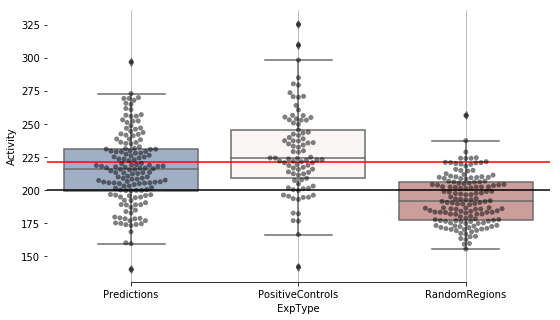

In [21]:
ListofExperiments = ['RandomRegions', 'Predictions','PositiveControls',
                     'OverlapsKRAB','NegativeControls','ChopCRX']


tempDF = CandidateADsToTestDF[CandidateADsToTestDF.Detected]

# sns.set_theme(style="ticks")


f, ax = plt.subplots(figsize=(9, 5))
# ax.set_xscale("log")

# # Plot the orbital period with horizontal boxes
# sns.boxplot(x='ExpType', y=Activity, data=tempDF,
#             width=.8, palette="vlag")

# # Add in points to show each observation
# sns.stripplot(x='ExpType', y=Activity, data=tempDF,
#               size=5, color=".3", linewidth=0)

# Tweak the visual presentation
# ax.xaxis.grid(True)
# ax.set(ylabel="")
# sns.despine(trim=True, left=True)
# plt.show()
# Plot the orbital period with horizontal boxes

indx = CandidateADsToTestDF.Detected &(CandidateADsToTestDF.Predictions|CandidateADsToTestDF.RandomRegions|CandidateADsToTestDF.PositiveControls)
tempDF = CandidateADsToTestDF[indx]
sns.swarmplot(x='ExpType', y=Activity, data=tempDF,color='k',alpha=.5
#               order=[ 'Negative Controls', 'Predicted ADs', 'Published ADs', 'Random Regions','ChopCRX',]
            )
sns.boxplot(x='ExpType', y=Activity, data=tempDF,
            width=.8, palette="vlag")


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Activity")
sns.despine(trim=True, left=True)
plt.plot([-1,3],[OnOffThresh,OnOffThresh],'r',label='95th percentile of random')
plt.plot([-1,3],[LowActivityThresh,LowActivityThresh],'k',label='No AD control')
plt.savefig('figures/'+Folder+'BoxPlot_all_wDots_Talks.pdf')
plt.show()